### Partition face dataset into 8:2 training:test

### Apply PCA on training data by use of eigenvectors and eigenvalues of covaraiance matrix S= (1/N)A(A^T)

### Apply PCA using eigenvectors and eigenvalues of (1/N)(A^T)A

In [2]:
# PCA source: Week 2 slides - Manifold Learning

import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import csv

np.random.seed(42)

data = loadmat('face.mat')

X = data['X'] # flat images dim (2576,520)
# l = data['l'].flatten()  # image Labels (1,520)

# Does a 8/2 split of dataset (8 images / 2 images of each person). Training data shuffled. 
def Q1_partition(data):
    X = data['X'] # flat images dim (2576,520)
    l = data['l'].flatten() 
    sets = [[], [], [], []]
    for i in range(0, 520, 10):
        im_train, im_test, l_train, l_test = train_test_split(X[:, i: i + 10].T, l[i: i + 10], test_size=0.2, random_state=42)
        sets[0].append(im_train)    
        sets[1].append(im_test)  
        sets[2].append(l_train)    
        sets[3].append(l_test)  

    for i in range(4):
        if i < 2:
             sets[i] = np.array(sets[i]).reshape(-1, 2576)
        else: 
            sets[i] = np.array(sets[i]).flatten()
    
    return sets

In [3]:
def display_image(image, label):
    # X[:, image_index]
    image_height, image_width = 46, 56 
    image = image.reshape((image_height, image_width)).T 
    # label = l[image_index]

    plt.imshow(image, cmap='gray', aspect='auto')
    plt.title(f"Face Image - Label: {label}")
    plt.axis('off')
    plt.show()
    # display_image(X_train[1:2].T, "hey")
    # display_image(t1[i:i+1].T, "Hey")

def get_sorted_eigen(M):
    eigenvalues, eigenvectors = np.linalg.eig(M)
    eigenvalues, eigenvectors = np.real(eigenvalues), np.real(eigenvectors)

    sorted_indices = np.argsort(eigenvalues)[::-1]

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    return sorted_eigenvalues, sorted_eigenvectors

# S = Covariance Matrix, A = mean centred data, N = #samples
def my_PCA(batch, k = 120, inverter = 0):
    A, mean, S = process_batch(batch, inverter)
    eigenvalues, eigenvectors = get_sorted_eigen(S)
    #k = choose_principal_components(threshold, eigenvalues)
    
    if inverter :
        eigenvectors = np.dot(A.T, eigenvectors)
        
        
    return eigenvalues[:k], eigenvectors[:, :k] / np.linalg.norm(eigenvectors[:, :k], axis=0), mean

def choose_principal_components(threshold, eigenvalues):
    covariance_ratios = eigenvalues/np.sum(eigenvalues)
    cum_var = 0
    for k, ratio in enumerate(covariance_ratios):
        cum_var += ratio
        if cum_var >= threshold: return k 

def process_batch(batch, inverter):
    mean = np.mean(batch, axis=0)
    A = batch - mean
    #print(f'batch: {batch.shape}')
    #print(f'A: {A.shape}')
    N = A.shape[1]
    
    if inverter :
        S = (1/N) * np.dot(A, A.T)
    else :
        S = (1/N) * np.dot(A.T, A)
        
    #print(f'S: {S.shape}')
    #print(f'Mean: {mean.shape}')
    return A, mean, S

In [14]:
# They cannot possibly be the same since they have different dimensions. 
[X_train, X_test, l_train, l_test] = Q1_partition(data)
##### Look here FELIX - AAT: S = (1/N) A * A^T, ATA: S = (1/N) A^T * A  
eigenvalues_AAT, eigenvectors_AAT, mean = my_PCA(X_train, 120)
eigenvalues_ATA, eigenvectors_ATA, mean = my_PCA(X_train, 120, 1)
##########


In [5]:
print(eigenvectors_AAT.shape, eigenvectors_ATA.shape)
print(np.sum(eigenvectors_AAT), np.sum(eigenvectors_ATA))

print(np.linalg.norm(eigenvectors_AAT, axis=1), np.linalg.norm(eigenvectors_ATA, axis=1))
print("First : ", eigenvectors_AAT[0])
print("Second : ", eigenvectors_ATA[0])

(2576, 120) (2576, 120)
17.09836678935076 42.157254370067186
[0.36371691 0.3515862  0.33107083 ... 0.27895705 0.28684273 0.29009899] [0.36371691 0.3515862  0.33107083 ... 0.27895705 0.28684273 0.29009899]
First :  [ 0.01472994  0.01506944  0.01368328 -0.00212099  0.00205137  0.02987084
  0.03898418 -0.02374239 -0.02601492 -0.01449653 -0.06196969  0.00180834
  0.05762447 -0.01748566  0.00114629  0.01096304  0.04146779 -0.00460401
  0.04323373 -0.04060662 -0.01319104  0.07086476  0.03124835 -0.00395564
  0.07332969 -0.01477371  0.01392507  0.00120364  0.01846917  0.01799603
 -0.00062567 -0.0309548   0.0088928  -0.03538652  0.01418866  0.09739486
  0.03884303  0.00542102 -0.00291703  0.03331836 -0.06394599  0.06124755
  0.01948048 -0.01451079  0.01982451 -0.04073729  0.03342207 -0.00158138
 -0.01288338 -0.05649824  0.0157733  -0.01146952  0.04045028 -0.00082575
  0.02398734 -0.01031053  0.04368411  0.00428108 -0.03498532 -0.01602389
  0.08078309 -0.00423329 -0.04412675 -0.01975444 -0.0717

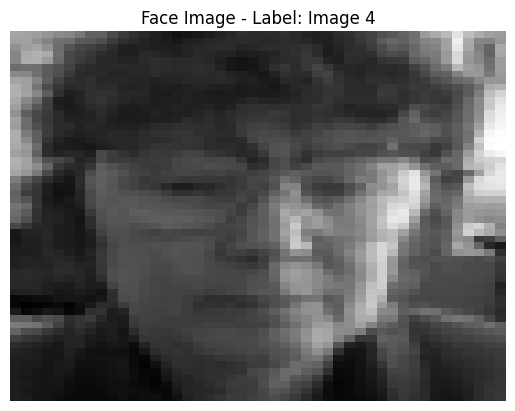

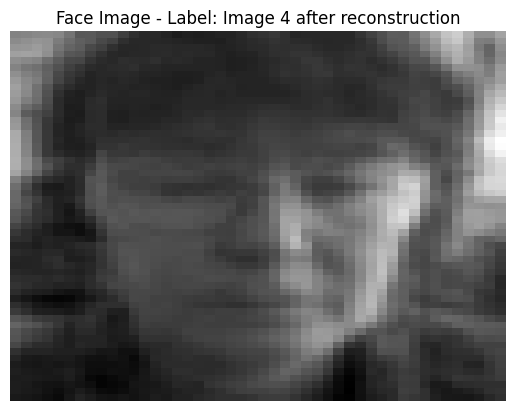

446.7139232474396


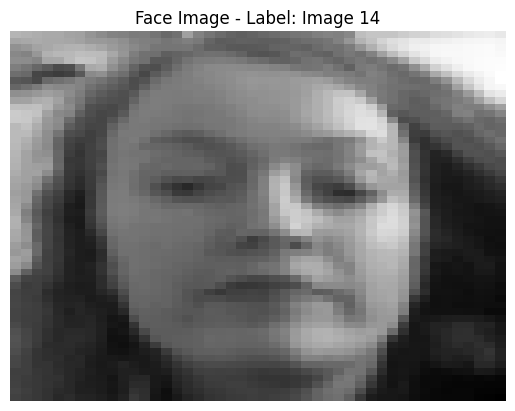

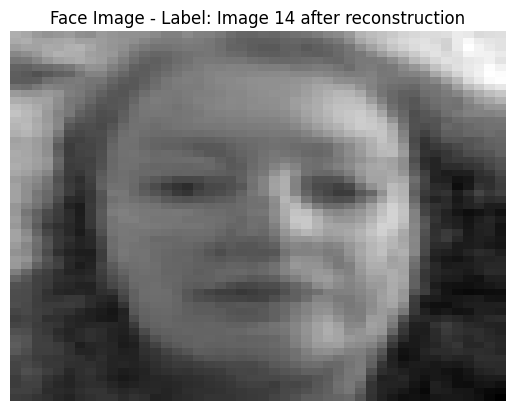

435.36913465540397


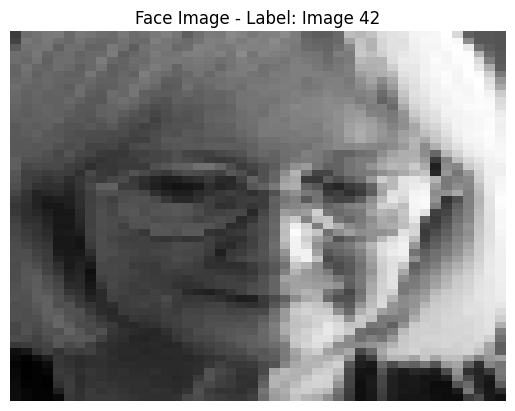

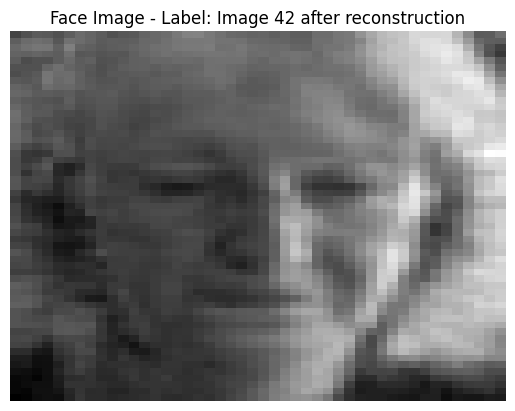

744.6006153518955
516.577208252739


In [17]:
def deconstruct(image, W, mean):
    centered_image = image - mean  # Step 1: Center the image
    Z = np.dot(centered_image, W)    # Step 2: Project onto principal components
    return Z

def reconstruct(Z, W, mean) :  
    #Reconstruct an image from its projection
    X_reconstructed = np.dot(Z, W.T) + mean  # Project back to original space
    return X_reconstructed

def test_image(img, W, mean, display=0, i=0):
    #Returns norm of reconstruction error, can display images
    
    Z = deconstruct(img, W, mean)
    re_img = reconstruct(Z, W, mean)
    
    if display & i!=0 :
        display_image(img, f"Image {i+1}")
        display_image(re_img, f"Image {i+1} after reconstruction")
    return(np.linalg.norm(img - re_img))
    
   
print(test_image(X[:, 3], eigenvectors_ATA, mean, 1, 3))
print(test_image(X[:, 13], eigenvectors_ATA, mean, 1, 13))
print(test_image(X[:, 41], eigenvectors_ATA, mean, 1, 41))
print(np.mean([test_image(X[:, i], eigenvectors_ATA, mean, 0) for i in range(len(X[0]))]))  #mean error


In [9]:
results = []
for M in range(10, 420, 10):
    eigenvalues, eigenvectors, mean = my_PCA(X_train, M, 1)
    res = np.mean([test_image(X[:, i], eigenvectors, mean, 0) for i in range(len(X[0]))])
    print("M : ", M)
    results.append([M, res])
    
with open("PCA_reconstruction.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(results)

M :  10
M :  20
M :  30
M :  40
M :  50
M :  60
M :  70
M :  80
M :  90
M :  100
M :  110
M :  120
M :  130
M :  140
M :  150
M :  160
M :  170
M :  180
M :  190
M :  200
M :  210
M :  220
M :  230
M :  240
M :  250
M :  260
M :  270
M :  280
M :  290
M :  300
M :  310
M :  320
M :  330
M :  340
M :  350
M :  360
M :  370
M :  380
M :  390
M :  400
M :  410


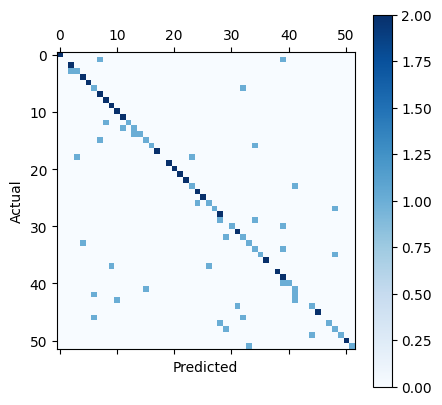

Accuracy :  0.6538461538461539


In [7]:
def testing_NN(image, projections, W, mean) :
    #Finds which training image correspond best to this image
    
    projected = deconstruct(image, W, mean)
    return np.argmin(np.linalg.norm((projections - projected), axis=1))

def fulltest(X_test, X_train, W, mean):
    #Compute all testing images and return guessed label
    
    projections = np.array([deconstruct(X_train[i], W, mean) for i in range(len(X_train))])
    res = []
    for image in X_test:
        res.append((testing_NN(image, projections, W, mean) //8) + 1)
    return np.array(res)

res = fulltest(X_test, X_train, eigenvectors_ATA, mean)

cm = confusion_matrix(l_test, res)

plt.matshow(cm, cmap = 'Blues')
plt.colorbar()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("Accuracy : ", sum(np.equal(res, l_test))/len(res))

In [8]:
def pca_test(X_train, X_test, M):
    pca = PCA(n_components=M)
    pca.fit(X_train)
    Xr = pca.transform(X_train)
    Xt = pca.transform(X_test)
    res = []
    
    for image in Xt:
        res.append(np.argmin(np.linalg.norm((Xr - image), axis=1)) // 8 + 1)
    return np.array(res)


[X_train, X_test, l_train, l_test] = Q1_partition(data)


results = []

for M in range(10, 420, 10):
    eigenvalues, eigenvectors, mean = my_PCA(X_train, M, 1)
    res = fulltest(X_test, X_train, eigenvectors, mean)
    res2 = pca_test(X_train, X_test, M)
    print("M : ", M)
    print("Accuracy (1) : ", sum(np.equal(res, l_test))/len(res))
    print("Accuracy (2) : ", sum(np.equal(res2, l_test))/len(res2))
    
    results.append([M, sum(np.equal(res, l_test))/len(res)])

with open("PCA_accuracy.csv", mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(results)
   

M :  10
Accuracy (1) :  0.49038461538461536
Accuracy (2) :  0.49038461538461536
M :  20
Accuracy (1) :  0.5673076923076923
Accuracy (2) :  0.5673076923076923
M :  30
Accuracy (1) :  0.625
Accuracy (2) :  0.625
M :  40
Accuracy (1) :  0.6153846153846154
Accuracy (2) :  0.6153846153846154
M :  50
Accuracy (1) :  0.6346153846153846
Accuracy (2) :  0.6346153846153846
M :  60
Accuracy (1) :  0.6346153846153846
Accuracy (2) :  0.6442307692307693
M :  70
Accuracy (1) :  0.6442307692307693
Accuracy (2) :  0.6538461538461539
M :  80
Accuracy (1) :  0.6634615384615384
Accuracy (2) :  0.6538461538461539
M :  90
Accuracy (1) :  0.6634615384615384
Accuracy (2) :  0.6634615384615384
M :  100
Accuracy (1) :  0.6634615384615384
Accuracy (2) :  0.6730769230769231
M :  110
Accuracy (1) :  0.6634615384615384
Accuracy (2) :  0.6634615384615384
M :  120
Accuracy (1) :  0.6538461538461539
Accuracy (2) :  0.6538461538461539
M :  130
Accuracy (1) :  0.6634615384615384
Accuracy (2) :  0.6538461538461539
M :  1